In [2]:
import os 
import numpy as np
import pandas as pd
import numpy as np

from classes.matlab_reader import matlab_reader
from classes.grid_funcs import map_grid,dataset,data_wizard
from datetime import datetime



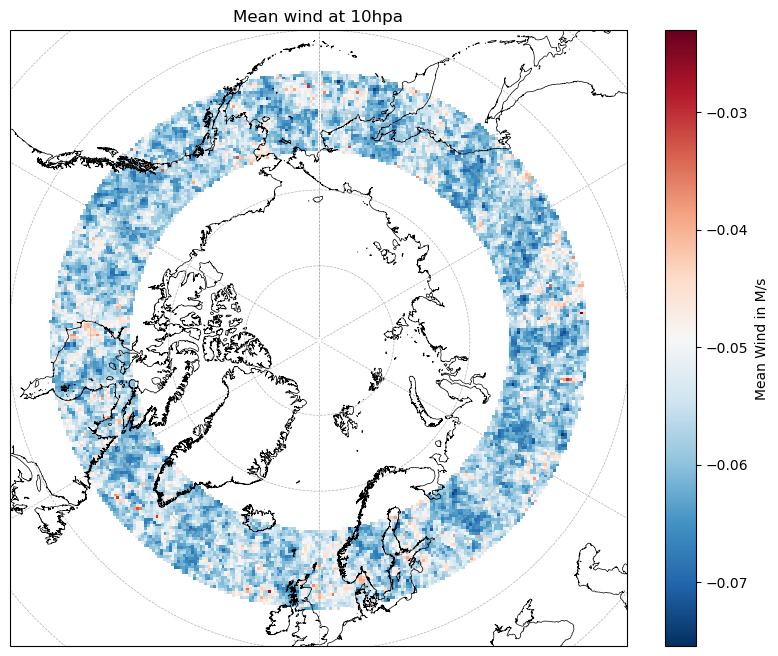

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

data = np.load('processed_airs_sftp/40_km_grid/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

fig = plt.figure(figsize=(10, 8))

ax = plt.axes(projection=ccrs.NorthPolarStereo())

ax.coastlines(resolution='10m', linewidth=0.5)
ax.gridlines(linewidth=0.5, linestyle='--')

ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree()) # New extent

plt.pcolormesh(grid.nh_lon, grid.nh_lat, data, cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())

plt.colorbar(label='Mean Wind in M/s')

plt.title(f'Mean wind at 10hpa')

plt.show()


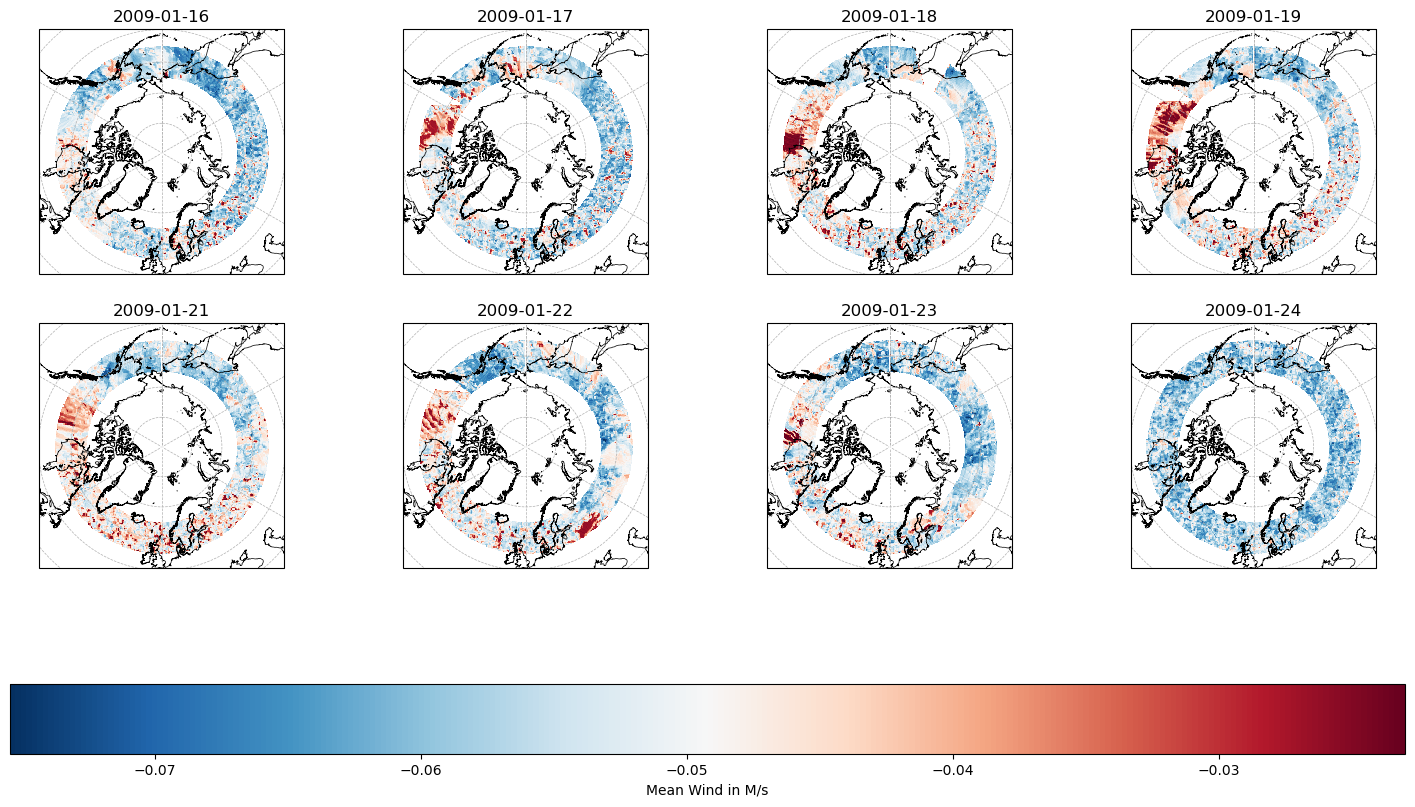

In [14]:
# =================================================================================================
# Plot on Colormesh (absolute momentum flux)
# =================================================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

dates = [
"2009-01-16",
"2009-01-17",
"2009-01-18",
"2009-01-19",
"2009-01-21",
"2009-01-22",
"2009-01-23",
"2009-01-24"]

data_1 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-11_mfx.npz')['arr_0']
data_2 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-12_mfx.npz')['arr_0']
data_3 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-13_mfx.npz')['arr_0']
data_4 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-14_mfx.npz')['arr_0']
data_5 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-15_mfx.npz')['arr_0']
data_6 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-16_mfx.npz')['arr_0']
data_7 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_8 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-18_mfx.npz')['arr_0']

data_dict = {'data_1': data_1,
            'data_2': data_2,
            'data_3': data_3,
            'data_4': data_4,
            'data_5': data_5,
            'data_6': data_6,
            'data_7': data_7,
            'data_8': data_8}
            
# Load data and create grid
data = np.load('processed_airs_sftp/40_km_grid/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

# Create figure with two subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Flatten the 2D array of subplots into a 1D array
axs = axs.ravel()

data_i = 1
# Loop over subplots and plot data
for i, ax in enumerate(axs):
    # Set extent for subplot
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    # Plot data
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, linestyle='--')
    ax.pcolormesh(grid.nh_lon, grid.nh_lat, data_dict[f'data_{data_i}'], cmap='RdBu_r', shading='auto', transform=ccrs.PlateCarree())
    ax.set_title(dates[data_i-1])
    # Increment i
    data_i += 1

# Add a colorbar to the figure and put it to the right side of the subplots

cbar = fig.colorbar(axs[-1].pcolormesh(grid.nh_lon,grid.nh_lat,data,
cmap='RdBu_r',
shading='auto',
transform=ccrs.PlateCarree()),
ax=axs.tolist(),
location='bottom')

cbar.set_label('Mean Wind in M/s')

# # Adjust spacing between subplots


# Show the plot
plt.show()


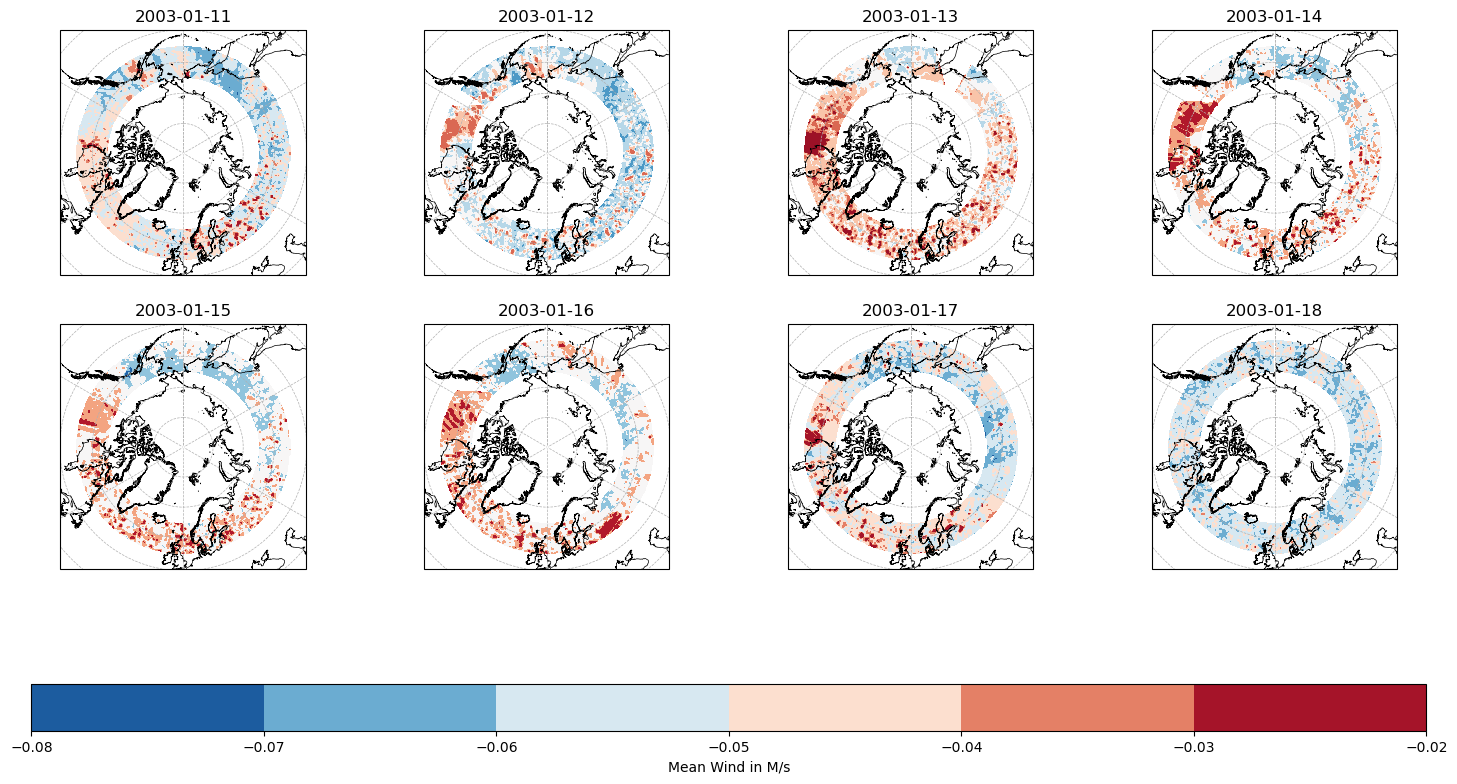

In [10]:
# =================================================================================================
# Plot on contous (absolute momentum flux)
# =================================================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load data and create grid
# Load data and create grid

dates = ["2003-01-11","2003-01-12","2003-01-13","2003-01-14","2003-01-15","2003-01-16","2003-01-17","2003-01-18"]

data_1 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-11_mfx.npz')['arr_0']
data_2 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-12_mfx.npz')['arr_0']
data_3 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-13_mfx.npz')['arr_0']
data_4 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-14_mfx.npz')['arr_0']
data_5 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-15_mfx.npz')['arr_0']
data_6 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-16_mfx.npz')['arr_0']
data_7 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_8 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-18_mfx.npz')['arr_0']

data_dict = {'data_1': data_1,
            'data_2': data_2,
            'data_3': data_3,
            'data_4': data_4,
            'data_5': data_5,
            'data_6': data_6,
            'data_7': data_7,
            'data_8': data_8}

grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

# Create figure with two subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 10), subplot_kw={'projection': ccrs.NorthPolarStereo()})

# Flatten the 2D array of subplots into a 1D array
axs = axs.ravel()

data_i = 1
# Loop over subplots and plot data
for i, ax in enumerate(axs):
    # Set extent for subplot
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    # Plot data as contours
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, linestyle='--')
    ax.contourf(grid.nh_lon, grid.nh_lat, data_dict[f'data_{data_i}'], levels=5, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.set_title(dates[data_i-1])
    # Increment i
    data_i += 1

# Add a colorbar to the figure and put it to the right side of the subplots
cbar = fig.colorbar(axs[-1].contourf(grid.nh_lon, grid.nh_lat, data, levels=5, cmap='RdBu_r', transform=ccrs.PlateCarree()),
                    ax=axs.tolist(),
                    location='bottom',
                    aspect=30)
cbar.set_label('Mean Wind in M/s')

# Show the plot
plt.show()


0
1
2
3
4
5
6
7


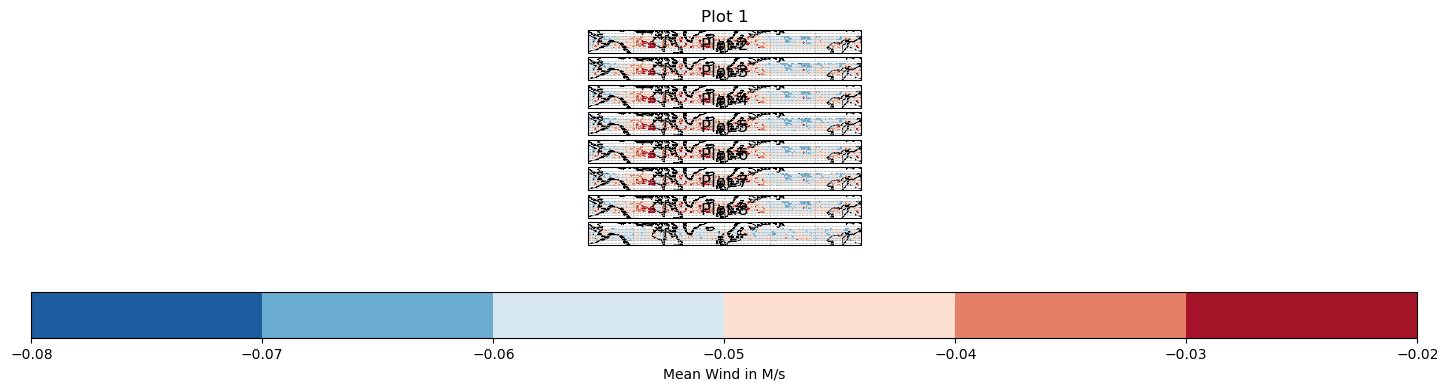

In [38]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Load data and create grid
data_1 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_2 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_3 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_4 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_5 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_6 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_7 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']
data_8 = np.load('processed_airs_sftp/40_km_grid/mfx/2003-01-17_mfx.npz')['arr_0']

data_dict = {'data_1': data_1,
                'data_2': data_2,
                'data_3': data_3,
                'data_4': data_4,
                'data_5': data_5,
                'data_6': data_6,
                'data_7': data_7,
                'data_8': data_8}


grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

# Create figure with eight subplots
fig, axs = plt.subplots(8, 1, figsize=(10, 20), subplot_kw={'projection': ccrs.Miller()})

# Loop over subplots and plot data
for i, ax in enumerate(axs):
    print(i)
    # Set extent for subplot
    ax.set_extent([-180, 180, 50, 70], crs=ccrs.PlateCarree())

    # Plot data as contours
    ax.coastlines(resolution='10m', linewidth=0.5)
    ax.gridlines(linewidth=0.5, linestyle='--')
    ax.contourf(grid.nh_lon, grid.nh_lat, data_dict[f'data_{i+1}'], levels=5, cmap='RdBu_r', transform=ccrs.PlateCarree())
    ax.set_title(f'Plot {i+1}')

# Add a colorbar to the figure and put it below the subplots
cbar = fig.colorbar(axs[-1].contourf(grid.nh_lon, grid.nh_lat, data, levels=5, cmap='RdBu_r', transform=ccrs.PlateCarree()),
                    ax=axs.tolist(),
                    location='bottom',
                    aspect=30)
cbar.set_label('Mean Wind in M/s')

# Show the plot
plt.show()


/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_7309/3513694083.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(grid.nh_lon, grid.nh_lat, data,latlon=True, cmap='RdBu_r',shading='auto')


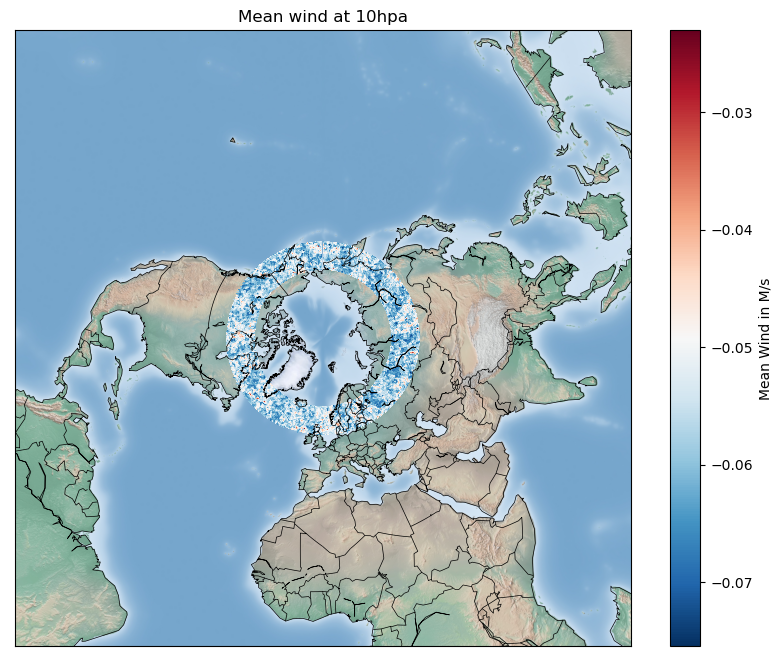

In [3]:
# =============================================================================
# Plot data for testing (40km grid)
# =============================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

data = np.load('processed_airs_sftp/40_km_grid/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='40', source='airs')
wizard = data_wizard()

fig = plt.figure(figsize=(10, 8))

m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')
m.shadedrelief(scale=0.5)

# use to plot areas in any section of the globe using a stereographic projection
# m = Basemap(projection='stere',llcrnrlat=-80,urcrnrlat=80,\
#             llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

m.pcolormesh(grid.nh_lon, grid.nh_lat, data,latlon=True, cmap='RdBu_r',shading='auto')
m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')


plt.title(f'Mean wind at 10hpa')
plt.colorbar(label='Mean Wind in M/s')


/var/folders/p6/325r0tsd2cd1jddpt9nd70hm0000gn/T/ipykernel_5172/4188593221.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(grid.nh_lon, grid.nh_lat, data,latlon=True, cmap='RdBu_r',shading='auto')


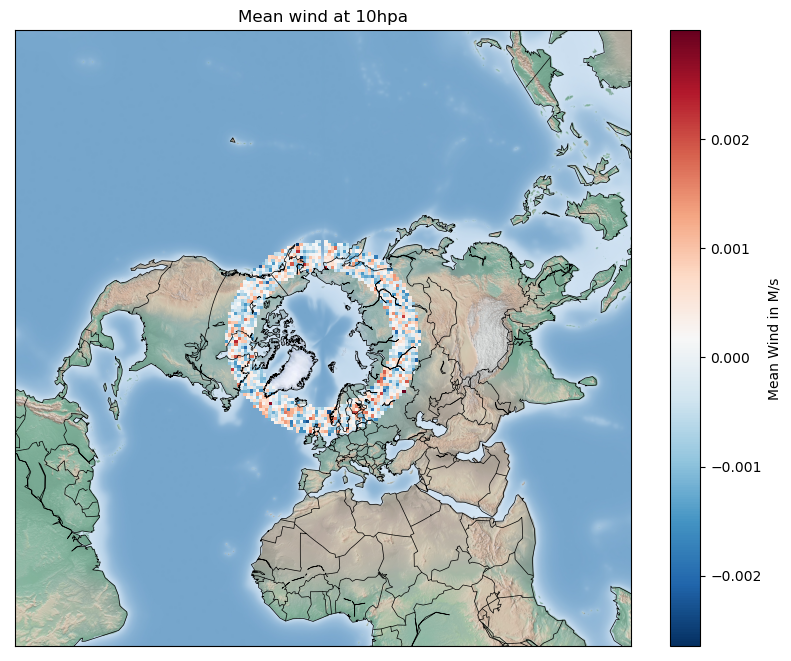

In [10]:
# =============================================================================
# Plot data for testing (40km grid)
# =============================================================================

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

data = np.load('processed_airs_sftp/125_km_grid/mfx/2002-08-31_mfx.npz')['arr_0']
grid = map_grid(grid_size='125', source='airs')
wizard = data_wizard()

fig = plt.figure(figsize=(10, 8))

m = Basemap(projection='npstere',boundinglat=0,lon_0=0,resolution='c')
m.shadedrelief(scale=0.5)

# use to plot areas in any section of the globe using a stereographic projection
# m = Basemap(projection='stere',llcrnrlat=-80,urcrnrlat=80,\
#             llcrnrlon=-180,urcrnrlon=180,lat_ts=20,resolution='c')

m.pcolormesh(grid.nh_lon, grid.nh_lat, data,latlon=True, cmap='RdBu_r',shading='auto')
m.drawcoastlines(linewidth=0.5,linestyle='solid')
m.drawcountries(linewidth=0.5, linestyle='solid',color='k')


plt.title(f'Mean wind at 10hpa')
plt.colorbar(label='Mean Wind in M/s')
